<a href="https://colab.research.google.com/github/code-with-dhruv/Cube/blob/main/HFE_Lattice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

# Load a sample dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')


Processing...
Done!


In [4]:
def hfe_transform(x, degree=2):
    """
    Applies a simple polynomial transformation to simulate HFE-like transformation.
    This is a toy example and doesn't represent the full complexity of HFE.
    """
    transformed_x = x ** degree
    return transformed_x


In [5]:
class HFEGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HFEGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Apply HFE transformation
        x = hfe_transform(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HFEGNN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


In [7]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
accuracy = correct / int(data.test_mask.sum())
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7970


In [9]:
# Step 1: Ensure the node features require gradients
data.x.requires_grad = True

# Step 2: Forward pass to compute the loss
model.eval()
output = model(data)
loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

# Step 3: Backward pass to calculate gradients
model.zero_grad()
loss.backward()

# Obtain gradients for the node features
data_grad = data.x.grad.data

# Step 4: Define the FGSM attack
def fgsm_attack(data, epsilon, gradient):
    # Generate perturbed data using the gradient sign
    perturbed_data = data + epsilon * gradient.sign()
    # Clip the data to ensure valid range (optional, depending on your data constraints)
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Example for normalized data
    return perturbed_data

# Generate adversarial examples using the calculated gradients
epsilon = 0.1  # Perturbation magnitude
perturbed_data = fgsm_attack(data.x, epsilon, data_grad)

# Replace original node features with perturbed ones
data.x = perturbed_data

# Step 5: Evaluate the model on the adversarially perturbed data
output = model(data)
_, pred = output.max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
adversarial_accuracy = correct / int(data.test_mask.sum())
print(f'Adversarial Accuracy: {adversarial_accuracy:.4f}')


Adversarial Accuracy: 0.7920


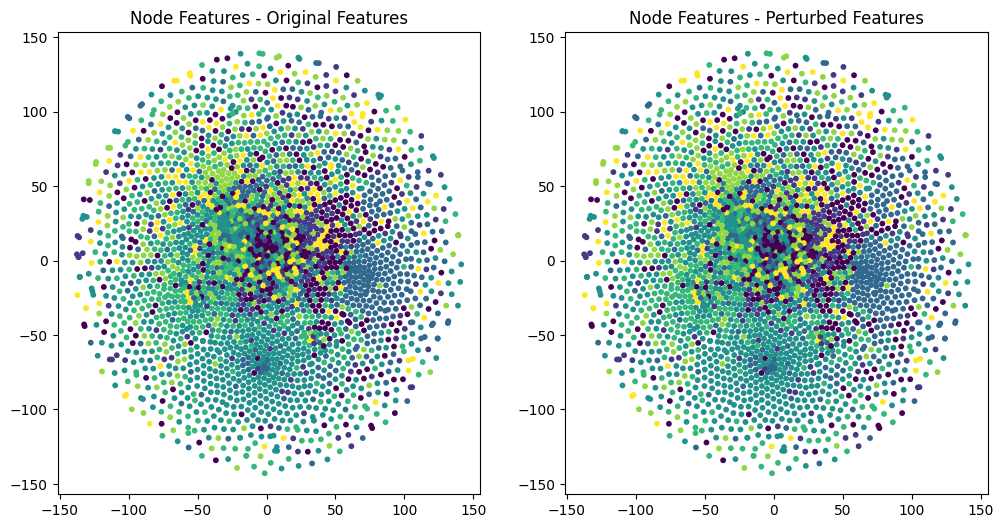

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_node_features(original_features, perturbed_features, labels, title):
    """
    Visualize node features before and after perturbation using t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42)

    # Combine original and perturbed features for visualization
    all_features = torch.cat([original_features, perturbed_features], dim=0).detach().cpu().numpy()

    tsne_results = tsne.fit_transform(all_features)

    # Split back into original and perturbed sets
    tsne_original = tsne_results[:original_features.shape[0]]
    tsne_perturbed = tsne_results[original_features.shape[0]:]

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(tsne_original[:, 0], tsne_original[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.title(f'{title} - Original Features')

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_perturbed[:, 0], tsne_perturbed[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.title(f'{title} - Perturbed Features')

    plt.show()

# Assume `data.x` is the original node features and `perturbed_data` are the adversarially perturbed features
original_features = data.x.detach().clone()
labels = data.y

visualize_node_features(original_features, perturbed_data, labels, "Node Features")


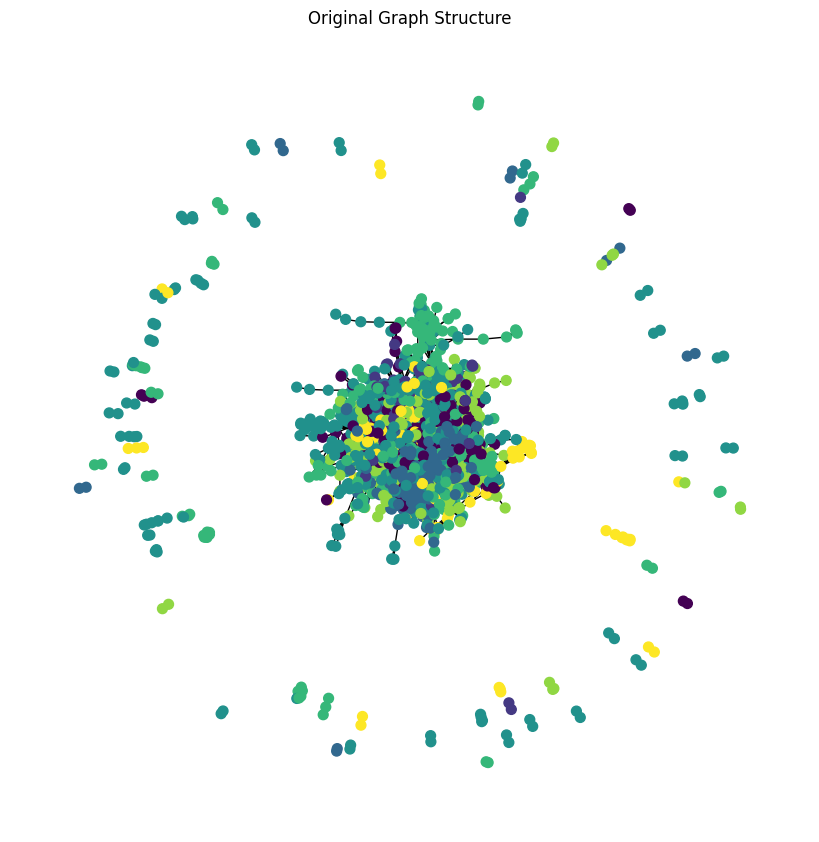

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(data, title):
    """
    Visualize the graph with nodes colored by their labels.
    """
    plt.figure(figsize=(8, 8))
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G)  # Layout for better visualization

    # Draw the graph with node coloring based on labels
    nx.draw(G, pos, node_color=data.y.cpu().numpy(), cmap='viridis', node_size=50, with_labels=False)
    plt.title(title)
    plt.show()

# Visualize the original and perturbed graph structures
visualize_graph(data, "Original Graph Structure")

# Assuming the graph structure is perturbed, visualize the perturbed graph
# Here we assume data contains the perturbed graph, replace `data` if using different variable
# visualize_graph(data, "Perturbed Graph Structure")


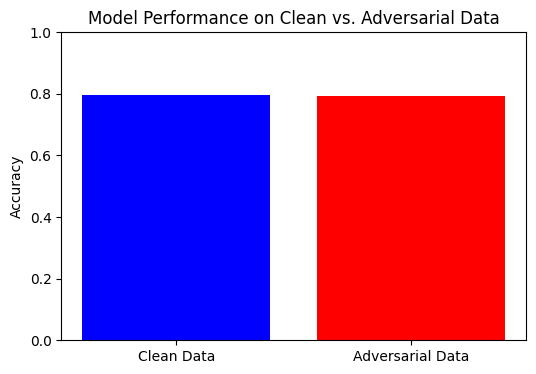

In [12]:
def plot_performance_metrics(clean_accuracy, adversarial_accuracy):
    """
    Plot accuracy on clean and adversarial data.
    """
    labels = ['Clean Data', 'Adversarial Data']
    accuracies = [clean_accuracy, adversarial_accuracy]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, accuracies, color=['blue', 'red'])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Model Performance on Clean vs. Adversarial Data')
    plt.show()

# Assuming `clean_accuracy` and `adversarial_accuracy` are calculated
clean_accuracy = accuracy  # From the earlier code before perturbation
adversarial_accuracy = adversarial_accuracy  # From the earlier code after perturbation

plot_performance_metrics(clean_accuracy, adversarial_accuracy)


In [13]:
from torch_geometric.data import DataLoader

# Loading the dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Assuming we're using the existing masks for train, validation, and test
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask


In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Define the GNN model
class HFEGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HFEGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Apply HFE transformation (simple example)
        x = hfe_transform(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the HFE transformation
def hfe_transform(x, degree=2):
    return x ** degree

# Initialize the model, optimizer, and other components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HFEGNN(dataset.num_node_features, dataset.num_classes).to(device)
data = data.to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Example: Try different learning rates and weight decay values
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)


# Metrics storage
train_losses = []
val_losses = []
val_accuracies = []

# Training loop with epoch tracking
epochs = 2000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = F.nll_loss(val_out[val_mask], data.y[val_mask]).item()
        val_losses.append(val_loss)

        _, val_pred = val_out[val_mask].max(dim=1)
        val_correct = val_pred.eq(data.y[val_mask]).sum().item()
        val_accuracy = val_correct / val_mask.sum().item()
        val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch: 1, Train Loss: 1.9381, Val Loss: 1.9016, Val Accuracy: 0.3000
Epoch: 2, Train Loss: 1.8772, Val Loss: 1.8616, Val Accuracy: 0.3520
Epoch: 3, Train Loss: 1.8101, Val Loss: 1.8148, Val Accuracy: 0.4320
Epoch: 4, Train Loss: 1.7373, Val Loss: 1.7660, Val Accuracy: 0.4880
Epoch: 5, Train Loss: 1.6609, Val Loss: 1.7177, Val Accuracy: 0.5340
Epoch: 6, Train Loss: 1.5839, Val Loss: 1.6706, Val Accuracy: 0.5800
Epoch: 7, Train Loss: 1.5071, Val Loss: 1.6242, Val Accuracy: 0.6160
Epoch: 8, Train Loss: 1.4305, Val Loss: 1.5782, Val Accuracy: 0.6480
Epoch: 9, Train Loss: 1.3547, Val Loss: 1.5324, Val Accuracy: 0.6620
Epoch: 10, Train Loss: 1.2799, Val Loss: 1.4871, Val Accuracy: 0.6700
Epoch: 11, Train Loss: 1.2067, Val Loss: 1.4423, Val Accuracy: 0.6840
Epoch: 12, Train Loss: 1.1354, Val Loss: 1.3980, Val Accuracy: 0.6940
Epoch: 13, Train Loss: 1.0663, Val Loss: 1.3545, Val Accuracy: 0.7060
Epoch: 14, Train Loss: 0.9995, Val Loss: 1.3120, Val Accuracy: 0.7100
Epoch: 15, Train Loss: 0.9348

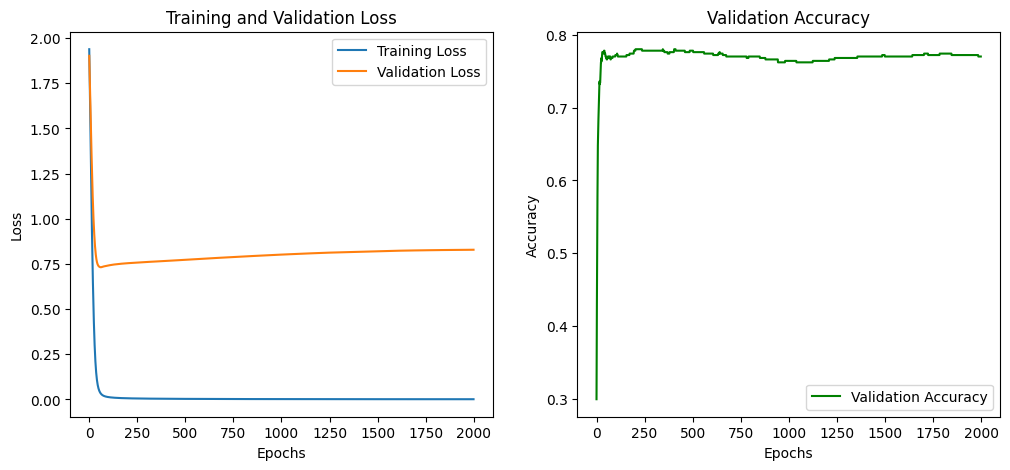

In [25]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()
